### Load Packages

In [16]:
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import get_file
import matplotlib.pyplot as plt

## Problem Definition

<img src="https://imgur.com/OVABmio.png" width="500">

우리에게는 3가지 이미지가 있습니다. 세 이미지 모두 고객이 관심을 유도하여, 제품 페이지 클릭을 유도하기 위해 설계되어 있습니다. 즉 높은 클릭율(CTR)일수록 좋은 이미지입니다. 하지만 우리는 셋 중 어느 이미지가 높은 CTR을 가질지를 모릅니다. 이 때 우리는 어떻게 시도하는 것이 좋을까요?

마케팅 상황을 재현하기 위해 아래에 `simulator` 클래스를 구현하였습니다. 매 고객 별로 어떤 상품을 노출시키냐에 따라 클릭할지 안할지를 알려주는 역할을 합니다.

In [34]:
class Simulator:
    fpath = get_file(
        'ads_simulation.csv',
        'https://docs.google.com/uc?id=1uHFOZ0DTHaX45f26xCbj_G3eptRblXiu')
    simulation_cases = pd.read_csv(fpath)
    def __init__(self):
        self.idx = 0
        self.selections = ["case1", "case2", "case3"]
    
    def choose(self, selection):
        assert selection in self.selections
        self.idx += 1
        idx = self.idx % 10000
        return bool(self.simulation_cases.loc[idx,selection])

In [54]:
# 시뮬레이터 생성하기
simulator = Simulator()

시뮬레이터의 `choose()`은 매번 고객에게 노출시킨 후 고객이 페이지를 클릭했는지 안했는지를 평가받는 메소드입니다. 아래와 같이 반복적으로 호출함으로써, 고객에 대한 반응을 수집할 수 있습니다.

In [35]:
print(" case1으로 고객에게 노출한 경우")
results = []
for i in range(10):
    reward = simulator.choose('case1')
    results.append(reward)
print("10번 시도 중 결과: {} 성공 / {} 실패 \n".format(sum(results), 10 - sum(results)))
    
print(" case2으로 고객에게 노출한 경우")
results = []
for i in range(10):
    reward = simulator.choose('case1')
    results.append(reward)

print("10번 시도 중 결과: {} 성공 / {} 실패 \n".format(sum(results), 10 - sum(results)))

print(" case3으로 고객에게 노출한 경우")
results = []
for i in range(10):
    reward = simulator.choose('case1')
    results.append(reward)
print("10번 시도 중 결과: {} 성공 / {} 실패 \n".format(sum(results), 10 - sum(results)))

 case1으로 고객에게 노출한 경우
10번 시도 중 결과: 1 성공 / 9 실패 

 case2으로 고객에게 노출한 경우
10번 시도 중 결과: 4 성공 / 6 실패 

 case3으로 고객에게 노출한 경우
10번 시도 중 결과: 5 성공 / 5 실패 



## 톰슨 샘플링 알고리즘 구현하기

![](https://t4.daumcdn.net/thumb/R720x0/?fname=http://t1.daumcdn.net/brunch/service/user/IgT/image/zSSTskSW0U73xmBRHsYyHsPJHsQ.png)

In [55]:
from scipy.stats import beta

class ThompsonSamplingAgent:
    def __init__(self, cases=["case1", "case2", "case3"]):
        self.params = pd.DataFrame(np.ones((3,2)),
                                   columns=['alpha','beta'], 
                                   index=cases)
        self._last_chosen = None
        
    def choose(self):
        """
        """
        # 각 case 별 beta dist sampling
        case_probs = { 
            case : np.random.beta(row.alpha, row.beta) 
            for case, row in self.params.iterrows()}
        
        # Maximization하는 확률 추론
        chosen_case = max(case_probs.items(), 
                          key=lambda kv : kv[1])[0]
        
        self._last_chosen = chosen_case
        return chosen_case
    
    def update(self, reward):
        """
        """
        if reward:
            # success
            self.params.loc[self._last_chosen, "alpha"] += 1
        else:
            # fail
            self.params.loc[self._last_chosen, "beta"] += 1
            
    def visualize_pdf(self, title=""):
        """
        """
        for name, row in self.params.iterrows():
            xs = np.linspace(0+1e-5,1-1e-5,200)
            ys = beta.pdf(xs, row.alpha, row.beta)
            plt.plot(xs,ys,label=name)
        plt.title(title)
        plt.legend()
        plt.show()
        
    def expectation(self):
        """
        """
        alphas = self.params.alpha
        betas = self.params.beta
        return  alphas / (alphas + betas)

### 톰슨 샘플링을 통한 시뮬레이션

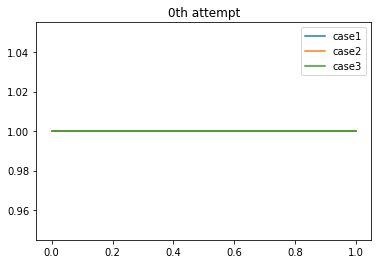

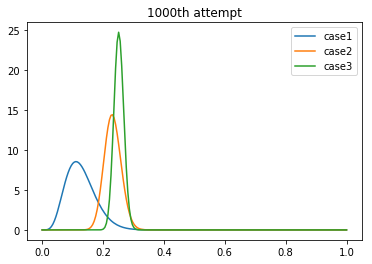

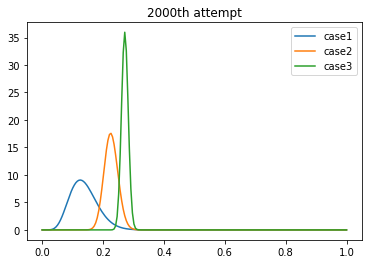

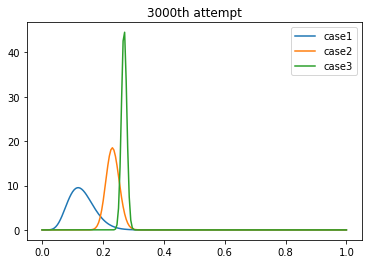

In [52]:
agent = ThompsonSamplingAgent()

history = []
for idx in range(0, 3000+1):
    # Visualization
    if idx % 1000 == 0:
        agent.visualize_pdf(f'{idx}th attempt')
    chosen = agent.choose()
        
    # Update Distribution
    click = simulator.choose(chosen)
    
    # update Agent
    agent.update(click)
    
    # save expectation
    history.append(agent.expectation())

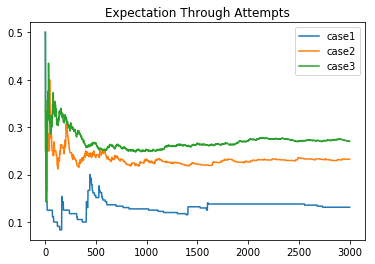

In [53]:
pd.concat(history, axis=1).T.plot(title="Expectation Through Attempts")
plt.show()